# Testing OpenCV functionality

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# algo = "MOG2"
algo = "KNN"

frames = []
if algo == "MOG2":
    backsub = cv2.createBackgroundSubtractorMOG2()
elif algo == "KNN":
    backsub = cv2.createBackgroundSubtractorKNN()

x_min = 0
x_max = 200
y_min = 0
y_max = 200

for ep_num in range(0, 1000, 100):
    ep_frames = []
    cam = cv2.VideoCapture(
        # "../../src/sport/outputs/2025-01-10/12-03-59/videos/rl-video-episode-{ep_num}.mp4".format(
        "../../src/sport/outputs/2025-01-10/13-03-47/videos/rl-video-episode-{ep_num}.mp4".format(
            ep_num=ep_num
        )
    )
    while True:
        ret, frame = cam.read()
        if not ret:
            break
        frame = frame[x_min:x_max, y_min:y_max]
        fgmask = backsub.apply(frame, learningRate=0.01)
        ep_frames.append(frame)
        frames.append(ep_frames)

# For some reason, each video for ep_num > 0 has 1 extra frame at the start from the end of the previous episode
for idx in range(1, len(frames)):
    frames[idx] = frames[idx][1:]

cam.release()

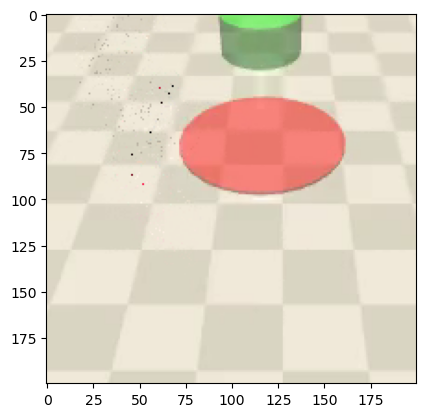

In [3]:
plt.imshow(
    cv2.cvtColor(backsub.getBackgroundImage().astype("uint8"), cv2.COLOR_BGR2RGB)
)
plt.show()

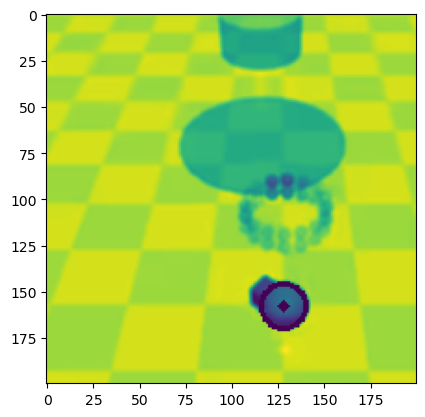

In [4]:
gray = cv2.cvtColor(frames[0][1], cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.blur(gray, (3, 3))
detected_circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    1,
    10,
    param1=50,
    param2=30,
    minRadius=1,
    maxRadius=60,
)

if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        cv2.circle(gray_blurred, (a, b), r, (0, 255, 0), 2)
        cv2.circle(gray_blurred, (a, b), 1, (0, 0, 255), 3)
plt.imshow(gray_blurred)
plt.show()

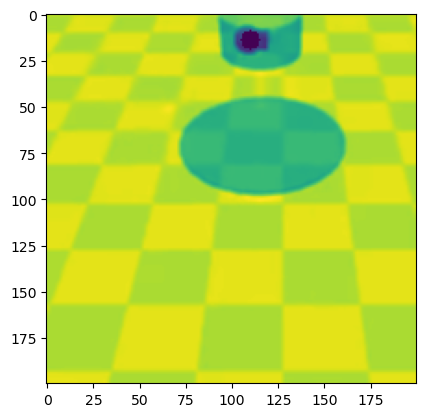

In [5]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)

gray = cv2.cvtColor(frames[0][14], cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.blur(gray, (3, 3))

keypoints = detector.detect(gray_blurred)

for kp in keypoints:
    if kp.size <= 40:
        x, y = kp.pt
        x, y = int(x), int(y)
        cv2.circle(gray_blurred, (x, y), 5, (0, 0, 255), -1)

plt.imshow(gray_blurred)
plt.show()

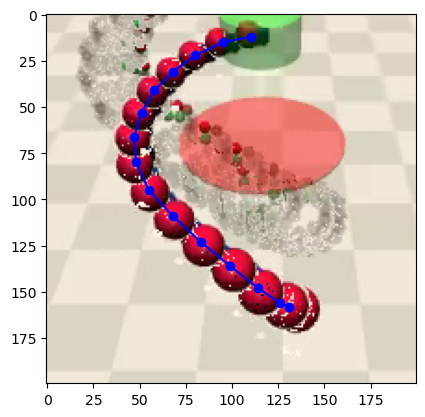

In [6]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)

update_rate = 1.0
keypoint_size_cutoff = 40
trajectories = []
positions = []
for ep_frames in frames:
    trajectory = backsub.getBackgroundImage()
    ep_positions = []
    for idx in range(len(ep_frames)):
        fgmask = backsub.apply(ep_frames[idx])
        trajectory[fgmask > 0] = (
            trajectory[fgmask > 0] * (1 - update_rate)
            + ep_frames[idx][fgmask > 0] * update_rate
        )
        gray = cv2.cvtColor(ep_frames[idx], cv2.COLOR_BGR2GRAY)
        gray_blurred = cv2.blur(gray, (3, 3))
        keypoints = detector.detect(gray_blurred)

        for kp in keypoints:
            if kp.size <= keypoint_size_cutoff:
                x, y = kp.pt
                x, y = int(x), int(y)
                ep_positions.append((x, y))
    trajectories.append(trajectory)
    positions.append(ep_positions)
plt.imshow(cv2.cvtColor(trajectory.astype("uint8"), cv2.COLOR_BGR2RGB))
# Extract x and y coordinates from ep_positions
x_coords = [pos[0] for pos in ep_positions]
y_coords = [pos[1] for pos in ep_positions]

plt.plot(x_coords, y_coords, linestyle="-", marker="o", color="b")
plt.show()

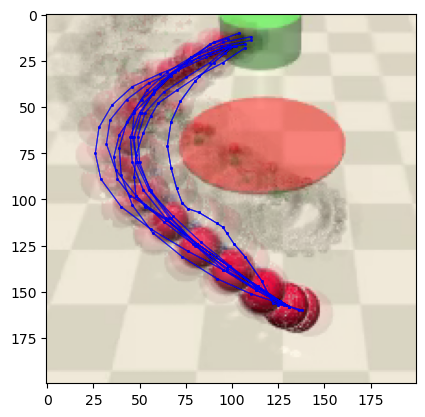

In [7]:
trajectory_distribution = np.mean(trajectories, axis=0)

plt.imshow(cv2.cvtColor(trajectory_distribution.astype("uint8"), cv2.COLOR_BGR2RGB))

for ep_positions in positions:
    # Extract x and y coordinates from ep_positions
    x_coords = [pos[0] for pos in ep_positions]
    y_coords = [pos[1] for pos in ep_positions]

    plt.plot(
        x_coords,
        y_coords,
        linestyle="-",
        linewidth="0.7",
        marker="o",
        markersize="1",
        color="b",
        alpha=0.1,
    )

plt.show()